In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

## Exploratory Data Analysis and Preproccessing

In [2]:
# import tweets
tweets = pd.read_csv("../data/Tweets_historical/historic_tweets_official_07262019.csv")

In [3]:
tweets.head()

,date,geo,hashtags,id,text,type,username
0,2016-10-11 16:39:51+00:00,NaN,NaN,785882618852147201,The PIOH for the SR 138/I-20 is going on now u...,official,GDOTATL
1,2016-10-10 19:10:23+00:00,NaN,NaN,785558112682053632,We appreciate all the hard work our crews have...,official,GDOTATL
2,2016-10-09 17:30:22+00:00,NaN,NaN,785170555456647168,Need info on re-entry? Check here! Also follow...,official,GDOTATL
3,2016-10-09 15:45:11+00:00,NaN,NaN,785144083685793792,Do you need some updates? You can find ALL of ...,official,GDOTATL
4,2016-10-09 14:00:20+00:00,NaN,NaN,785117697583427585,Did you know that the @511Georgia website and ...,official,GDOTATL


In [4]:
accounts = tweets['username'].unique()

In [5]:
accounts

array(['GDOTATL', 'SCDOTMidlands', 'SCDOTPeeDee', 'SCDOTLowCountry',
       'SCDOTPiedmont', '511statewideva', 'fl511_panhandl', '511Georgia',
       'fl511_state', 'fl511_northeast', 'fl511_southeast',
       'fl511_southwest', 'fl511_tampabay', 'fl511_central',
       '511centralva', '511hamptonroads', '511northernva',
       'NCDOT_Westmtn', 'NCDOT_Triangle', 'NCDOT_Piedmont',
       'NCDOT_Charlotte', 'NCDOT_Asheville', 'NCDOT_Scoast',
       'NCDOT_Ncoast'], dtype=object)

In [6]:
state_dict = {'Georgia': ['GDOTATL', '511Georgia'], 
              'South Carolina' : ['SCDOTMidlands', 'SCDOTPeeDee', 'SCDOTLowCountry', 'SCDOTPiedmont'],
              'Florida' : ['fl511_panhandl', 'fl511_state', 'fl511_northeast', 'fl511_southeast', 'fl511_southwest', 'fl511_southwest', 'fl511_tampabay', 'fl511_central'],
              'Virginia' : ['511statewideva', '511centralva', '511hamptonroads', '511northernva'],
              'North Carolina' : ['NCDOT_Westmtn', 'NCDOT_Triangle', 'NCDOT_Piedmont', 'NCDOT_Charlotte', 'NCDOT_Asheville', 'NCDOT_Scoast', 'NCDOT_Ncoast']
             }

In [7]:
def state_remap(df, col, states):
    usernames = df[col]
    state_list = []
    for u in usernames:
        for key, val in states.items():
            if u in val:
                state_list.append(key)
    return state_list

In [8]:
tweets['state'] = state_remap(tweets, 'username', state_dict)
tweets['state'].value_counts()

Florida           12092
Virginia           8635
North Carolina     1951
South Carolina     1235
Georgia             141
Name: state, dtype: int64

In [9]:
# define function to plot count of words after count vectorization
# Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x, y, color = color)

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # create a list to collect the plt.patches data
    totals = []

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38,
                int(p.get_width()), fontsize=10)

In [10]:
# define function to run regex startments over a column labeled "text"
def twt_preprocess(twt):
    # run regex to remove urls
    twt['text'] = twt['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove non alphanumeric characters
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[@\?\.$%_\!\[\]()+:;\/*\"]", ' ', x, flags=re.I))
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))

    # run regex to remove common words
    twt['text'] = twt['text'].map(lambda x: re.sub('(twitter|tweet)[s]?', ' ', x,  flags=re.I))   
    

In [11]:
# run regex cleaner on full dataframe
twt_preprocess(tweets)

#### Create Dataframe of Tweets that mention keywords related to road closures

In [12]:
# establish list of words to search for in dataframe
closed_keywords = ['road closed', 'remains closed', 'closed',
                   'no travel', 'delay', 'lane', 
                   'disabled', 'traffic', 'fire', 'flood']

to_drop = ["open", "opened", "lifted", "plane", "reopened", "clear", "cleared"]

In [13]:
# define function to filter the full dataframe for tweets that contain words from a keyword list
def tweet_filter (df, col, keywords, dropwords=None):
    
    query = []
    
    # populate query list with masks that test if a word is in datafram
    for word in keywords:
        mask = df[col].str.contains(word, regex=False, case=False)
        query.append(mask)
        
    # run filter, specifying ANY text
    filter_df = df[np.any(query, axis=0)]
    
    # test words to drop functionality
    if dropwords is not None:
        
        # drop words in drop words list
        return filter_df[~filter_df[col].str.contains('|'.join(dropwords))]
    
    else:
        return filter_df

In [14]:
# backup original tweet to new dataframe
tweets['tweet'] = tweets['text']

# make tweet text lowercase
tweets['text'] = tweets['text'].str.lower()

# run function on full dataframe
closed = tweet_filter(tweets, 'text', closed_keywords, to_drop)

In [15]:
# Create target variable 
closed['road_closure'] = 1
closed['tweet']

14       You may drive a large truck or SUV but it only...
15       Hurricanes can produce deadly flooding hundred...
18       High winds will be prevalent tonight at above ...
26       For up to date traffic info be sure to visit  ...
33       The exit ramp from I-16 WB to I-75 NB has been...
40       All construction related lane closures on I-75...
42       We are ready to deal with traffic control as #...
64       Update  Vehicle on fire  I-26 WB  at I126-Colu...
65       Update  Vehicle on fire  I-26 WB  at I126-Colu...
84       Construction  SC 277 NB  at Park Lane Rd-Colum...
89       Update  Vehicle on fire  I-77 NB  at Exits 9A ...
91       Vehicle on fire  I-77 NB  at Exits 9A 9B-US76 ...
102      Update  Vehicle on fire  I-20 WB  1 mi W of Ex...
103      Update  Vehicle on fire  I-20 WB  1 mi W of Ex...
106      Update  Vehicle on fire  I-20 WB  1 mi W of Ex...
108      Update  Vehicle on fire  I-20 WB  1 mi W of Ex...
180      Update  Disabled veh  I-20 WB  at Exit74 no ln.

In [16]:
# find which accounts had information about road closures
closed['username'].value_counts()

fl511_southeast    1762
511northernva      1760
511centralva       1673
fl511_state        1615
fl511_northeast    1189
fl511_central      1181
511hamptonroads    1052
511statewideva      656
fl511_tampabay      531
NCDOT_Triangle      465
NCDOT_Scoast        393
fl511_southwest     310
NCDOT_Ncoast        277
NCDOT_Charlotte     127
fl511_panhandl      112
NCDOT_Piedmont       67
511Georgia           62
NCDOT_Asheville      52
SCDOTLowCountry      26
SCDOTMidlands        26
SCDOTPiedmont        17
SCDOTPeeDee          12
GDOTATL               7
NCDOT_Westmtn         1
Name: username, dtype: int64

In [17]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(closed['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(13373, 2772)


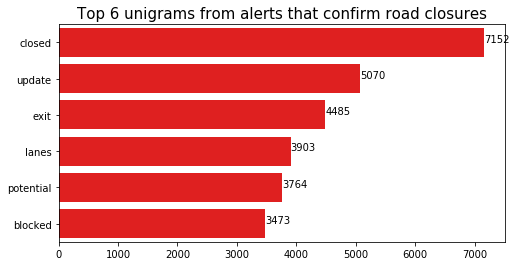

In [18]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from alerts that confirm road closures','r')

#### Create Dataframe of Tweets that do not mention closures

In [19]:
# Get index number of tweets identified as road closures 
closed_index = list(closed.index)

# Remove all road closure tweets from full dataframe
tweets_open = tweets.drop(closed_index)

# Drop any instances where false positives might occur
tweets_open = tweets_open[~tweets_open.text.str.contains("remains closed")]
tweets_open = tweets_open[~tweets_open.text.str.contains("remains close")]

# Shape
tweets_open.shape

(10681, 9)

In [20]:
# To maintain balanced classes, drop rows in `tweets_open` so that they are equal to `closed`
tweets_open = tweets_open.iloc[0:(closed.shape[0])]

In [21]:
# Create target variable 
tweets_open['road_closure'] = 0
tweets_open.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
0,2016-10-11 16:39:51+00:00,NaN,NaN,785882618852147201,the pioh for the sr 138 i-20 is going on now u...,official,GDOTATL,Georgia,The PIOH for the SR 138 I-20 is going on now u...,0
1,2016-10-10 19:10:23+00:00,NaN,NaN,785558112682053632,we appreciate all the hard work our crews have...,official,GDOTATL,Georgia,We appreciate all the hard work our crews have...,0
2,2016-10-09 17:30:22+00:00,NaN,NaN,785170555456647168,need info on re-entry check here also follow...,official,GDOTATL,Georgia,Need info on re-entry Check here Also follow...,0
3,2016-10-09 15:45:11+00:00,NaN,NaN,785144083685793792,do you need some updates you can find all of ...,official,GDOTATL,Georgia,Do you need some updates You can find ALL of ...,0
4,2016-10-09 14:00:20+00:00,NaN,NaN,785117697583427585,did you know that the 511georgia website and ...,official,GDOTATL,Georgia,Did you know that the 511Georgia website and ...,0


In [22]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(tweets_open['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(10681, 2836)


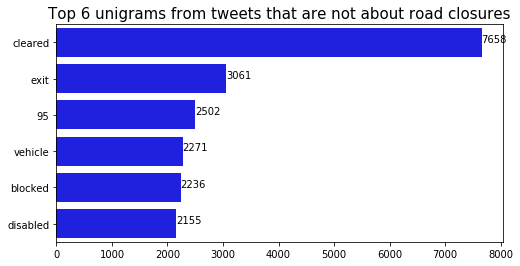

In [23]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from tweets that are not about road closures','b')

#### Create Training Dataframe

In [24]:
# Merge dataframes
tweets_training = pd.concat([tweets_open, closed], axis=0)
tweets_training.shape

(24054, 10)

In [25]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
0,2016-10-11 16:39:51+00:00,NaN,NaN,785882618852147201,the pioh for the sr 138 i-20 is going on now u...,official,GDOTATL,Georgia,The PIOH for the SR 138 I-20 is going on now u...,0
1,2016-10-10 19:10:23+00:00,NaN,NaN,785558112682053632,we appreciate all the hard work our crews have...,official,GDOTATL,Georgia,We appreciate all the hard work our crews have...,0
2,2016-10-09 17:30:22+00:00,NaN,NaN,785170555456647168,need info on re-entry check here also follow...,official,GDOTATL,Georgia,Need info on re-entry Check here Also follow...,0
3,2016-10-09 15:45:11+00:00,NaN,NaN,785144083685793792,do you need some updates you can find all of ...,official,GDOTATL,Georgia,Do you need some updates You can find ALL of ...,0
4,2016-10-09 14:00:20+00:00,NaN,NaN,785117697583427585,did you know that the 511georgia website and ...,official,GDOTATL,Georgia,Did you know that the 511Georgia website and ...,0


## Modeling

In [26]:
# Baseline score
tweets_training['road_closure'].value_counts(normalize=True)

1    0.555957
0    0.444043
Name: road_closure, dtype: float64

In [27]:
# define our variables
X = tweets_training['text']
y = tweets_training['road_closure']

In [28]:
# train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [29]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.5s finished


Best score: 0.9980044345898005
Train score 0.9998337028824834
Test score 0.9978383771200532


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

In [30]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec = CountVectorizer(ngram_range=(1, 3), stop_words= 'english')

# Fit and transform the vectorizor
cvec.fit(X_train)

cvec_train = cvec.transform(X_train)
cvec_test = cvec.transform(X_test)

# Fit the classifier
lr.fit(cvec_train,y_train)

# Create the predictions for Y training data
y_pred = lr.predict(cvec_test)

print(f'Train Score: {lr.score(cvec_train, y_train)}')
print(f'Test Score: {lr.score(cvec_test, y_test)}')

Train Score: 1.0
Test Score: 0.9986697705354174


In [31]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[2668    2]
 [   6 3338]]


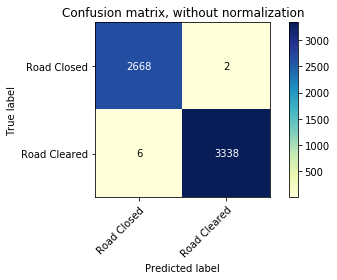

In [32]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['Road Closed', 'Road Cleared'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

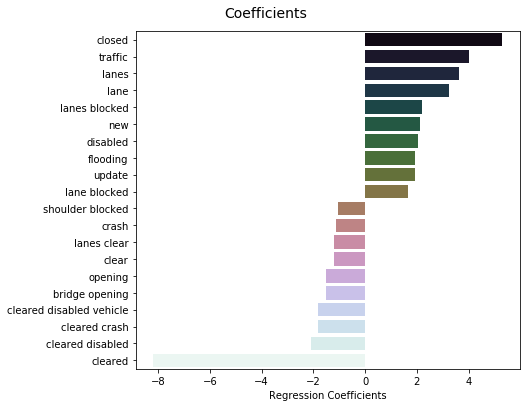

In [33]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec.get_feature_names(), columns = ["lr_coef"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'lr_coef', 
ascending = False)

# Create top and bottom 10 
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients', size=14)
ax = sns.barplot(x = 'lr_coef', y= df_merged.index, 
data=df_merged, palette= 'cubehelix')
ax.set(xlabel='Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [39]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
0,2016-10-11 16:39:51+00:00,NaN,NaN,785882618852147201,the pioh for the sr 138 i-20 is going on now u...,official,GDOTATL,Georgia,The PIOH for the SR 138 I-20 is going on now u...,0
1,2016-10-10 19:10:23+00:00,NaN,NaN,785558112682053632,we appreciate all the hard work our crews have...,official,GDOTATL,Georgia,We appreciate all the hard work our crews have...,0
2,2016-10-09 17:30:22+00:00,NaN,NaN,785170555456647168,need info on re-entry check here also follow...,official,GDOTATL,Georgia,Need info on re-entry Check here Also follow...,0
3,2016-10-09 15:45:11+00:00,NaN,NaN,785144083685793792,do you need some updates you can find all of ...,official,GDOTATL,Georgia,Do you need some updates You can find ALL of ...,0
4,2016-10-09 14:00:20+00:00,NaN,NaN,785117697583427585,did you know that the 511georgia website and ...,official,GDOTATL,Georgia,Did you know that the 511Georgia website and ...,0


In [40]:
tweets_training.to_csv('../data/cleaned_tweets/cleaned_historic_official_07302019.csv', index = False)